In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from Models import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go


In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [88]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

TsAD = importr('otsad')
TSdist = importr('TSdist')

Load and Prepare data to input to LSTM model

In [4]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [7]:
def modify_test_data(test_set, mean, variance):
    
    noise = np.random.normal(mean, variance, len(test_set))
    modified_test_Set = test_set + noise

    return modified_test_Set

In [8]:
train_set, test_set = splitData(data['Close'].values)

In [9]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [11]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

In [12]:
train_norm, test_norm = normalize_data(train_set, test_set)
train_norm, test_norm = normalize_data(train_set, test_set)

x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
# x_train_cluster, y_train_cluster = prepareDataForTraining(train_set)
# x_test_cluster, y_test_cluster = prepareDataForTraining(test_set)

In [14]:
# x_train_cluster = np.asarray(x_train_cluster).reshape(-1, window_size, 1)
# y_train_cluster = np.asarray(y_train_cluster).reshape(-1, 1)
# x_test_cluster = np.asarray(x_test_cluster).reshape(-1, window_size, 1)
# y_test_cluster = np.asarray(y_test_cluster).reshape(-1, 1)

In [15]:
# print('x_train_cluster.shape = ',x_train_cluster.shape)
# print('y_train_cluster.shape = ',y_train_cluster.shape)
# print('x_test_cluster.shape = ',x_test_cluster.shape)
# print('y_test_cluster.shape = ',y_test_cluster.shape)

# x_train_cluster = torch.from_numpy(x_train_cluster).type(torch.Tensor)
# x_test_cluster = torch.from_numpy(x_test_cluster).type(torch.Tensor)
# y_train_cluster = torch.from_numpy(y_train_cluster).type(torch.Tensor)
# y_test_cluster = torch.from_numpy(y_test_cluster).type(torch.Tensor)

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))

# fig.update_xaxes(range=["2018-07-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [16]:
num_clusters = 5

In [17]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clusters,                          
                          metric="dtw",                          
                          max_iter_barycenter=10,
                          random_state=23)

#without normalization
# y_pred = dba_km.fit(x_train_cluster) : Only displays the cluster centres (in red) and the training data is not assigned to any cluster as 
# predict(train) is not done.

y_pred = dba_km.fit_predict(x_train)

DBA k-means


In [18]:
sz = x_train.shape[1]
sz

20

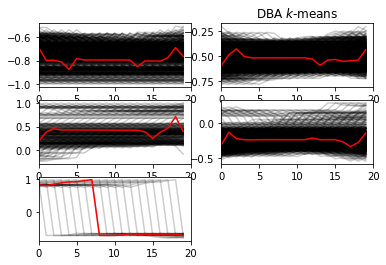

In [19]:
for yi in range(num_clusters):
    plt.subplot(3, 2, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.flatten(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    # plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
    #          transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

(0.0, 20.0)

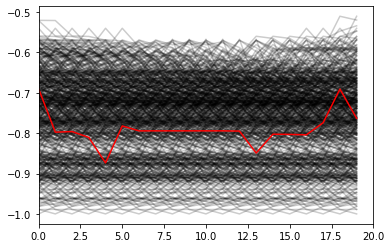

In [20]:
for xx in x_train[y_pred == 0]:    
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[0].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

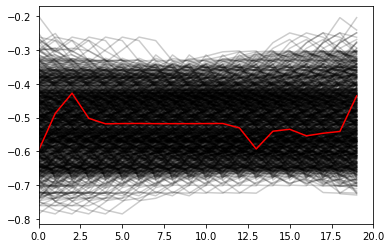

In [21]:
for xx in x_train[y_pred == 1]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[1].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

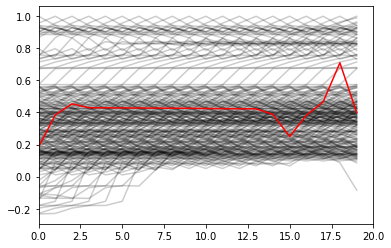

In [22]:
for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.xlim(0, sz)

In [33]:
len(x_train[y_pred == 2])

201

In [34]:
x_train[y_pred == 2]

tensor([[[-0.2326],
         [-0.2296],
         [-0.1963],
         ...,
         [ 0.2434],
         [ 0.2595],
         [ 0.2913]],

        [[-0.2296],
         [-0.1963],
         [-0.1799],
         ...,
         [ 0.2595],
         [ 0.2913],
         [ 0.2763]],

        [[-0.1963],
         [-0.1799],
         [-0.1801],
         ...,
         [ 0.2913],
         [ 0.2763],
         [ 0.2825]],

        ...,

        [[ 0.3313],
         [ 0.4192],
         [ 0.3822],
         ...,
         [ 0.4576],
         [ 0.3742],
         [ 0.4122]],

        [[ 0.4192],
         [ 0.3822],
         [ 0.4043],
         ...,
         [ 0.3742],
         [ 0.4122],
         [ 0.4649]],

        [[ 0.3822],
         [ 0.4043],
         [ 0.4110],
         ...,
         [ 0.4122],
         [ 0.4649],
         [ 0.4298]]])

In [35]:
x_test[:20]

tensor([[[0.4717],
         [0.4968],
         [0.5046],
         [0.4554],
         [0.3704],
         [0.2800],
         [0.1917],
         [0.1808],
         [0.1416],
         [0.1999],
         [0.1926],
         [0.2100],
         [0.2142],
         [0.3343],
         [0.3628],
         [0.3641],
         [0.3507],
         [0.3568],
         [0.3030],
         [0.3299]],

        [[0.4968],
         [0.5046],
         [0.4554],
         [0.3704],
         [0.2800],
         [0.1917],
         [0.1808],
         [0.1416],
         [0.1999],
         [0.1926],
         [0.2100],
         [0.2142],
         [0.3343],
         [0.3628],
         [0.3641],
         [0.3507],
         [0.3568],
         [0.3030],
         [0.3299],
         [0.3079]],

        [[0.5046],
         [0.4554],
         [0.3704],
         [0.2800],
         [0.1917],
         [0.1808],
         [0.1416],
         [0.1999],
         [0.1926],
         [0.2100],
         [0.2142],
         [0.3343],
        

(0.0, 20.0)

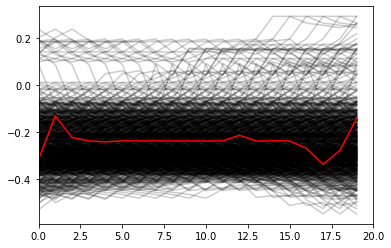

In [23]:
for xx in x_train[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.xlim(0, sz)

(0.0, 20.0)

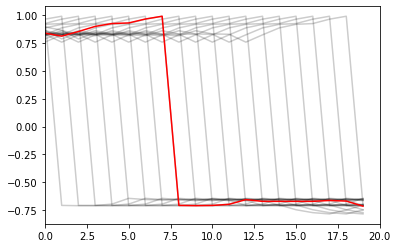

In [24]:
for xx in x_train[y_pred == 4]:    
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[4].ravel(), "r-")
plt.xlim(0, sz)

In [25]:
mean = []
std = []
var = []


for i in range(num_clusters):

    cluster = dba_km.cluster_centers_[i]

    mean.append(np.mean(cluster))
    std.append(np.std(cluster))
    var.append(np.var(cluster))
    

stats = pd.DataFrame({'mean': mean,
                    'standard deviation': std,
                    'variance': var

})

clusters = [i for i in range(num_clusters)]

stats.insert(0, 'clusters', clusters)
stats.set_index('clusters', inplace=True)


In [26]:
stats


,mean,standard deviation,variance
clusters,,,
0,-0.789886,0.040366,0.001629
1,-0.521724,0.039441,0.001556
2,0.415407,0.093832,0.008804
3,-0.239336,0.044641,0.001993
4,-0.050339,0.778360,0.605845


In [27]:
# train_norm, test_norm = normalize_data(train_set, test_set)
# train_norm, test_norm = normalize_data(train_set, test_set)

# x_train, y_train = prepareDataForTraining(train_norm)
# x_test, y_test = prepareDataForTraining(test_norm)

# x_train = np.asarray(x_train).reshape(-1, window_size, 1)
# y_train = np.asarray(y_train).reshape(-1, 1)
# x_test = np.asarray(x_test).reshape(-1, window_size, 1)
# y_test = np.asarray(y_test).reshape(-1, 1)

# x_train = torch.from_numpy(x_train).type(torch.Tensor)
# x_test = torch.from_numpy(x_test).type(torch.Tensor)
# y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [28]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [29]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:], y_test_pred)
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')

Test Score: 0.04 MAPE
R-squared value is 0.9143054072147314


#### Predict the cluster for test data

In [30]:
# x_train_cluster = TimeSeriesScalerMeanVariance().fit_transform(x_train_cluster)

In [31]:
res = dba_km.predict(x_test)

In [32]:
res

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [47]:
t1 = np.array(x_test[150])

In [50]:
t2 = np.array(x_test[204])

In [48]:
np.mean(t1), np.std(t1), np.var(t1)

(0.79770535, 0.059571404, 0.003548752)

In [52]:
np.mean(t2), np.std(t2), np.var(t2), res[204]

(0.0034342855, 0.3618606, 0.13094309, 3)

(0.0, 20.0)

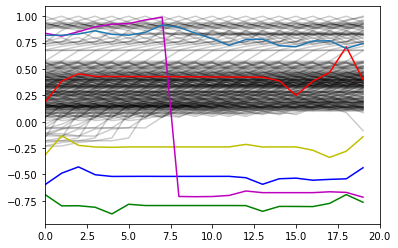

In [53]:
for xx in x_train[y_pred == 2]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[2].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[3].ravel(), "y-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "m-")
plt.plot(x_test[150])
plt.xlim(0, sz)

(0.0, 20.0)

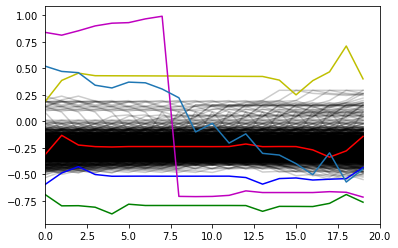

In [54]:
for xx in x_train[y_pred == 3]:
    plt.plot(xx.flatten(), "k-", alpha=.2)
plt.plot(dba_km.cluster_centers_[3].ravel(), "r-")
plt.plot(dba_km.cluster_centers_[0].ravel(), "g-")
plt.plot(dba_km.cluster_centers_[1].ravel(), "b-")
plt.plot(dba_km.cluster_centers_[2].ravel(), "y-")
plt.plot(dba_km.cluster_centers_[4].ravel(), "m-")
plt.plot(x_test[204])
plt.xlim(0, sz)

In [55]:
import spm1d

In [89]:
# dba_km.cluster_centers_[3], x_test[204]

x = dba_km.cluster_centers_[3].flatten()
y = np.array(x_test[204].flatten())
# X1 = rpy2.robjects.IntVector(x)
# X2 = rpy2.robjects.IntVector(x_test[204])

In [96]:
x = dba_km.cluster_centers_[2].flatten()
y = np.array(x_test[150].flatten())

In [97]:
X1 = rpy2.robjects.FloatVector(x)
X2 = rpy2.robjects.FloatVector(y)

In [93]:
X1

-0.316292,-0.132609,-0.224090,...,-0.338346,-0.279247,-0.142698


In [95]:
TSdist.CortDistance(X1, X2, deltamethod="DTW")

array([7.63576968])

In [98]:
TSdist.CortDistance(X1, X2, deltamethod="DTW")

array([11.84351467])